In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings

warnings.filterwarnings('ignore')

# Add src to path
import sys
sys.path.append('..')

from src.config import (
    SELECTED_DATA_PATH, SEQUENCES_DIR, SCALER_PATH,
    TARGET_COLUMN, DATE_COLUMN,
    INPUT_SEQ_LEN, OUTPUT_SEQ_LEN, MIN_SEGMENT_LENGTH,
    TRAIN_RATIO, VAL_RATIO, TEST_RATIO,
    RANDOM_SEED, set_seed
)
from src.dataset import create_sequences, create_sequences_from_segments, train_val_test_split
from src.data_preprocessing import split_continuous_segments
from src.utils import save_numpy, save_pickle

# Set random seed
set_seed(RANDOM_SEED)

print("Libraries imported successfully!")
print(f"Input sequence length: {INPUT_SEQ_LEN}")
print(f"Output sequence length: {OUTPUT_SEQ_LEN}")
print(f"Min segment length: {MIN_SEGMENT_LENGTH}")

Libraries imported successfully!
Input sequence length: 24
Output sequence length: 5
Min segment length: 48


## 5.1 Load Data & Split into Continuous Segments

**Vấn đề:** Dữ liệu có ~11,976 timestamps bị thiếu → không liên tục → không thể bịa nhãn.

**Giải pháp:** Tách thành nhiều segment liên tục, mỗi segment có nhãn thật 100%.

In [2]:
# Load data
df = pd.read_csv(SELECTED_DATA_PATH, parse_dates=[DATE_COLUMN])
print(f"Loaded data shape: {df.shape}")

# Check for NaN in target (missing labels)
n_missing_target = df[TARGET_COLUMN].isna().sum()
print(f"\nMissing target values: {n_missing_target}")

df.head()

Loaded data shape: (40575, 23)

Missing target values: 0


,date_time,traffic_volume,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos,hour,day_of_week,...,season,is_weekend,is_rush_hour,temp,clouds_all,rain_1h,snow_1h,is_rainy,is_snowy,rush_rain
0,2012-10-02 09:00:00,5545.0,7.071068e-01,-0.707107,0.781831,0.62349,-0.866025,0.5,9,1,...,2,0,1,288.28,40.0,0.0,0.0,0,0,0
1,2012-10-02 10:00:00,4516.0,5.000000e-01,-0.866025,0.781831,0.62349,-0.866025,0.5,10,1,...,2,0,0,289.36,75.0,0.0,0.0,0,0,0
2,2012-10-02 11:00:00,4767.0,2.588190e-01,-0.965926,0.781831,0.62349,-0.866025,0.5,11,1,...,2,0,0,289.58,90.0,0.0,0.0,0,0,0
3,2012-10-02 12:00:00,5026.0,1.224647e-16,-1.000000,0.781831,0.62349,-0.866025,0.5,12,1,...,2,0,0,290.13,90.0,0.0,0.0,0,0,0
4,2012-10-02 13:00:00,4918.0,-2.588190e-01,-0.965926,0.781831,0.62349,-0.866025,0.5,13,1,...,2,0,0,291.14,75.0,0.0,0.0,0,0,0


In [3]:
# Get feature columns (exclude date_time)
feature_columns = [c for c in df.columns if c != DATE_COLUMN]
print(f"Feature columns: {len(feature_columns)}")
print(feature_columns)

# Find target column index
target_idx = feature_columns.index(TARGET_COLUMN)
print(f"\nTarget column '{TARGET_COLUMN}' index: {target_idx}")

Feature columns: 22
['traffic_volume', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'hour', 'day_of_week', 'day_of_month', 'month', 'year', 'season', 'is_weekend', 'is_rush_hour', 'temp', 'clouds_all', 'rain_1h', 'snow_1h', 'is_rainy', 'is_snowy', 'rush_rain']

Target column 'traffic_volume' index: 0


In [4]:
# Split into continuous segments
# Now checks BOTH: valid target AND continuous timestamps (no gaps > 1 hour)
segments = split_continuous_segments(
    df, 
    date_col=DATE_COLUMN,
    target_col=TARGET_COLUMN, 
    min_length=MIN_SEGMENT_LENGTH,
    freq_hours=1  # Data should be hourly
)

print(f"\n✅ Total usable data from {len(segments)} continuous segments")

SEGMENT SPLITTING RESULTS
Original rows: 40,575
Gaps detected: 2,588
Segments created: 113
Segments skipped (too short < 48): 2476
Usable rows: 30,871 / 40,575 (76.1%)

Top 10 largest segments:
  Segment 94: 1,915 rows
  Segment 111: 1,588 rows
  Segment 88: 1,365 rows
  Segment 78: 1,007 rows
  Segment 99: 986 rows
  Segment 113: 933 rows
  Segment 105: 911 rows
  Segment 47: 894 rows
  Segment 109: 887 rows
  Segment 96: 876 rows

✅ Total usable data from 113 continuous segments


## 5.2 Data Scaling

**Quan trọng:** Fit scaler trên training portion của MỖI segment, không phải toàn bộ data.

In [5]:
# Combine all segments to fit scaler on training portion
all_data = []
for seg in segments:
    seg_data = seg[feature_columns].values
    all_data.append(seg_data)

# Concatenate all segment data
combined_data = np.concatenate(all_data, axis=0)
print(f"Combined data shape: {combined_data.shape}")

# Calculate training portion end (70% of total)
train_end = int(len(combined_data) * TRAIN_RATIO)
print(f"Training data: first {train_end:,} rows")

Combined data shape: (30871, 22)
Training data: first 21,609 rows


In [6]:
# Fit scaler on TRAINING portion only
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(combined_data[:train_end])

# Transform all combined data
data_scaled = scaler.transform(combined_data)

print(f"Data scaled. Min: {data_scaled.min():.4f}, Max: {data_scaled.max():.4f}")

Data scaled. Min: 0.0000, Max: 1.2000


In [7]:
# Split scaled data back into segments
scaled_segments = []
start_idx = 0
for seg in segments:
    seg_len = len(seg)
    scaled_seg = data_scaled[start_idx:start_idx + seg_len]
    scaled_segments.append(scaled_seg)
    start_idx += seg_len

print(f"Created {len(scaled_segments)} scaled segments")
for i, seg in enumerate(scaled_segments):
    print(f"  Segment {i+1}: {len(seg)} rows")

Created 113 scaled segments
  Segment 1: 48 rows
  Segment 2: 194 rows
  Segment 3: 71 rows
  Segment 4: 234 rows
  Segment 5: 130 rows
  Segment 6: 95 rows
  Segment 7: 170 rows
  Segment 8: 79 rows
  Segment 9: 54 rows
  Segment 10: 83 rows
  Segment 11: 77 rows
  Segment 12: 115 rows
  Segment 13: 128 rows
  Segment 14: 71 rows
  Segment 15: 79 rows
  Segment 16: 78 rows
  Segment 17: 93 rows
  Segment 18: 171 rows
  Segment 19: 120 rows
  Segment 20: 70 rows
  Segment 21: 266 rows
  Segment 22: 79 rows
  Segment 23: 48 rows
  Segment 24: 112 rows
  Segment 25: 397 rows
  Segment 26: 72 rows
  Segment 27: 182 rows
  Segment 28: 314 rows
  Segment 29: 127 rows
  Segment 30: 82 rows
  Segment 31: 81 rows
  Segment 32: 112 rows
  Segment 33: 70 rows
  Segment 34: 48 rows
  Segment 35: 51 rows
  Segment 36: 70 rows
  Segment 37: 53 rows
  Segment 38: 68 rows
  Segment 39: 81 rows
  Segment 40: 62 rows
  Segment 41: 56 rows
  Segment 42: 67 rows
  Segment 43: 158 rows
  Segment 44: 109 r

## 5.3 Create Sequences from Segments

**Workflow mới:** Tạo sequences từ mỗi segment độc lập → không có sequence nào chồng qua gap → tất cả nhãn đều thật.

In [8]:
# Create sequences from all segments
print("Creating sequences from segments...")
X, y = create_sequences_from_segments(
    segments=scaled_segments,
    target_idx=target_idx,
    input_seq_len=INPUT_SEQ_LEN,
    output_seq_len=OUTPUT_SEQ_LEN
)

print(f"\nX shape: {X.shape}  (samples, input_seq_len, n_features)")
print(f"y shape: {y.shape}  (samples, output_seq_len)")
print(f"\nAll labels are REAL (no interpolated targets)!")

Creating sequences from segments...
  Segment 1: created 20 sequences
  Segment 2: created 166 sequences
  Segment 3: created 43 sequences
  Segment 4: created 206 sequences
  Segment 5: created 102 sequences
  Segment 6: created 67 sequences
  Segment 7: created 142 sequences
  Segment 8: created 51 sequences
  Segment 9: created 26 sequences
  Segment 10: created 55 sequences
  Segment 11: created 49 sequences
  Segment 12: created 87 sequences
  Segment 13: created 100 sequences
  Segment 14: created 43 sequences
  Segment 15: created 51 sequences
  Segment 16: created 50 sequences
  Segment 17: created 65 sequences
  Segment 18: created 143 sequences
  Segment 19: created 92 sequences
  Segment 20: created 42 sequences
  Segment 21: created 238 sequences
  Segment 22: created 51 sequences
  Segment 23: created 20 sequences
  Segment 24: created 84 sequences
  Segment 25: created 369 sequences
  Segment 26: created 44 sequences
  Segment 27: created 154 sequences
  Segment 28: creat

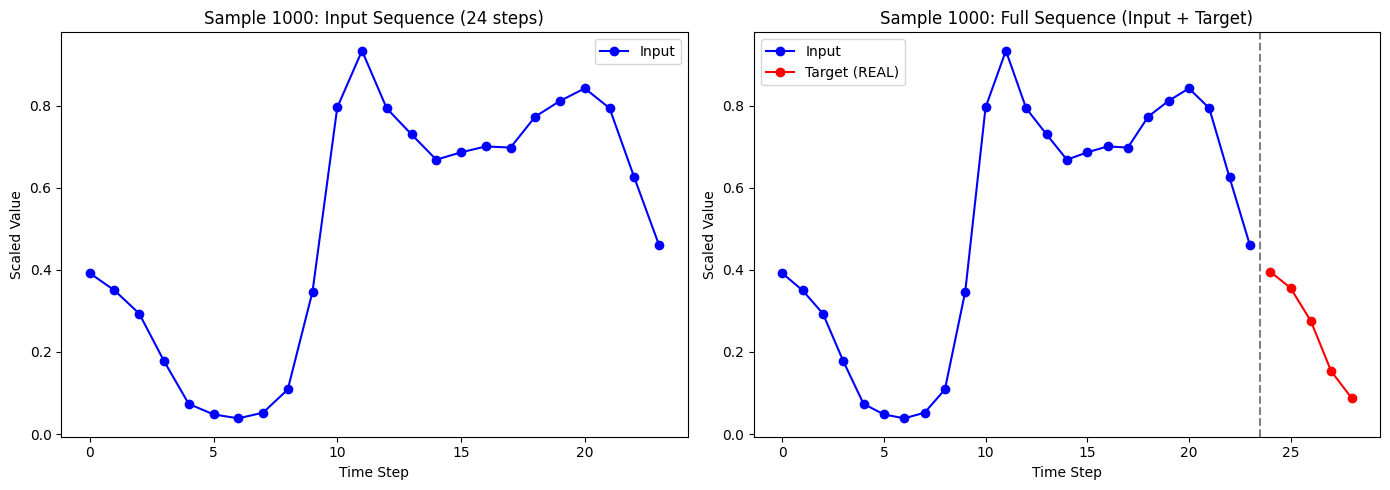

In [9]:
# Visualize a sample sequence
sample_idx = min(1000, len(X) - 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Input sequence (target column)
axes[0].plot(range(INPUT_SEQ_LEN), X[sample_idx, :, target_idx], 'b-o', label='Input')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Scaled Value')
axes[0].set_title(f'Sample {sample_idx}: Input Sequence ({INPUT_SEQ_LEN} steps)')
axes[0].legend()

# Full sequence (input + output)
axes[1].plot(range(INPUT_SEQ_LEN), X[sample_idx, :, target_idx], 'b-o', label='Input')
axes[1].plot(range(INPUT_SEQ_LEN, INPUT_SEQ_LEN + OUTPUT_SEQ_LEN), y[sample_idx], 'r-o', label='Target (REAL)')
axes[1].axvline(x=INPUT_SEQ_LEN - 0.5, color='gray', linestyle='--')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Scaled Value')
axes[1].set_title(f'Sample {sample_idx}: Full Sequence (Input + Target)')
axes[1].legend()

plt.tight_layout()
plt.show()

## 5.5 Train/Validation/Test Split

In [10]:
# Split data (time-based, no shuffle)
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(
    X, y,
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO
)

print(f"\nSplit ratio: {TRAIN_RATIO:.0%} / {VAL_RATIO:.0%} / {TEST_RATIO:.0%}")

Train: 19394 samples
Val:   4156 samples
Test:  4157 samples

Split ratio: 70% / 15% / 15%


In [11]:
# Verify shapes
print("\nData Shapes:")
print("=" * 50)
print(f"X_train: {X_train.shape}  →  {len(X_train):,} samples")
print(f"y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}   →  {len(X_val):,} samples")
print(f"y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}  →  {len(X_test):,} samples")
print(f"y_test:  {y_test.shape}")
print("=" * 50)
print(f"\nTotal: {len(X_train) + len(X_val) + len(X_test):,} sequences with REAL labels")


Data Shapes:
X_train: (19394, 24, 22)  →  19,394 samples
y_train: (19394, 5)
X_val:   (4156, 24, 22)   →  4,156 samples
y_val:   (4156, 5)
X_test:  (4157, 24, 22)  →  4,157 samples
y_test:  (4157, 5)

Total: 27,707 sequences with REAL labels


## 5.6 Save Data

In [12]:
import os

# Create sequences directory if not exists
os.makedirs(SEQUENCES_DIR, exist_ok=True)

# Save sequences
save_numpy(X_train, os.path.join(SEQUENCES_DIR, 'X_train.npy'))
save_numpy(y_train, os.path.join(SEQUENCES_DIR, 'y_train.npy'))
save_numpy(X_val, os.path.join(SEQUENCES_DIR, 'X_val.npy'))
save_numpy(y_val, os.path.join(SEQUENCES_DIR, 'y_val.npy'))
save_numpy(X_test, os.path.join(SEQUENCES_DIR, 'X_test.npy'))
save_numpy(y_test, os.path.join(SEQUENCES_DIR, 'y_test.npy'))

# Save scaler
save_pickle(scaler, SCALER_PATH)

# Save metadata
metadata = {
    'input_seq_len': INPUT_SEQ_LEN,
    'output_seq_len': OUTPUT_SEQ_LEN,
    'n_features': X_train.shape[2],
    'target_idx': target_idx,
    'feature_columns': feature_columns,
    'train_samples': len(X_train),
    'val_samples': len(X_val),
    'test_samples': len(X_test),
    'n_segments': len(segments),
    'segment_workflow': True,  # Flag to indicate segment-based workflow
    'all_labels_real': True    # Confirm no interpolated targets
}

from src.utils import save_json
save_json(metadata, os.path.join(SEQUENCES_DIR, 'metadata.json'))

print("\n✅ All data saved successfully!")
print(f"   Sequences: {SEQUENCES_DIR}")
print(f"   Scaler: {SCALER_PATH}")

Saved: d:\DeepLearning_final\data\sequences\X_train.npy
Saved: d:\DeepLearning_final\data\sequences\y_train.npy
Saved: d:\DeepLearning_final\data\sequences\X_val.npy
Saved: d:\DeepLearning_final\data\sequences\y_val.npy
Saved: d:\DeepLearning_final\data\sequences\X_test.npy
Saved: d:\DeepLearning_final\data\sequences\y_test.npy
Saved: d:\DeepLearning_final\models\scaler.pkl
Saved: d:\DeepLearning_final\data\sequences\metadata.json

✅ All data saved successfully!
   Sequences: d:\DeepLearning_final\data\sequences
   Scaler: d:\DeepLearning_final\models\scaler.pkl


## 5.7 Verify Saved Data

In [13]:
# Load and verify
X_train_loaded = np.load(os.path.join(SEQUENCES_DIR, 'X_train.npy'))
y_train_loaded = np.load(os.path.join(SEQUENCES_DIR, 'y_train.npy'))

print(f"Loaded X_train shape: {X_train_loaded.shape}")
print(f"Loaded y_train shape: {y_train_loaded.shape}")
print(f"\nData matches: {np.allclose(X_train, X_train_loaded) and np.allclose(y_train, y_train_loaded)}")

Loaded X_train shape: (19394, 24, 22)
Loaded y_train shape: (19394, 5)

Data matches: True


## Summary

**Data Preparation with Segment Workflow:**

| Bước | Mô tả |
|------|-------|
| 1 | Load dữ liệu đã feature engineering |
| 2 | Tách thành các segment liên tục (không có NaN target) |
| 3 | Scale dữ liệu (fit on training portion only) |
| 4 | Tạo sequences từ mỗi segment độc lập |
| 5 | Split train/val/test (time-based) |
| 6 | Save sequences & metadata |

**Ưu điểm của Segment Workflow:**
- ✅ **Không bịa nhãn** - Tất cả target đều là dữ liệu thật
- ✅ **Không data leakage** - Không interpolate target từ tương lai
- ✅ **Phù hợp Seq2Seq** - Mỗi sequence đảm bảo liên tục

**Next step:** Model Training (06_Model_Training.ipynb)